In [58]:
source("shared.R")
library(repr)

In [2]:
library("MASS")
data("OME")
?OME # background on the data
head(OME)

ID,Age,OME,Loud,Noise,Correct,Trials
1,30,low,35,coherent,1,4
1,30,low,35,incoherent,4,5
1,30,low,40,coherent,0,3
1,30,low,40,incoherent,1,1
1,30,low,45,coherent,2,4
1,30,low,45,incoherent,2,2


In [13]:
any(is.na(OME)) # check for missing values
dat = subset(OME, OME != "N/A") # manually remove OME missing values identified with "N/A"
dat$OME = factor(dat$OME)
str(dat)

[1] FALSE

'data.frame':	712 obs. of  7 variables:
 $ ID     : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Age    : int  30 30 30 30 30 30 30 30 30 30 ...
 $ OME    : Factor w/ 2 levels "high","low": 2 2 2 2 2 2 2 2 2 2 ...
 $ Loud   : int  35 35 40 40 45 45 50 50 55 55 ...
 $ Noise  : Factor w/ 2 levels "coherent","incoherent": 1 2 1 2 1 2 1 2 1 2 ...
 $ Correct: int  1 4 0 1 2 2 3 4 3 2 ...
 $ Trials : int  4 5 3 1 4 2 3 4 3 2 ...


In [63]:
options(repr.plot.width=8, repr.plot.height=5)

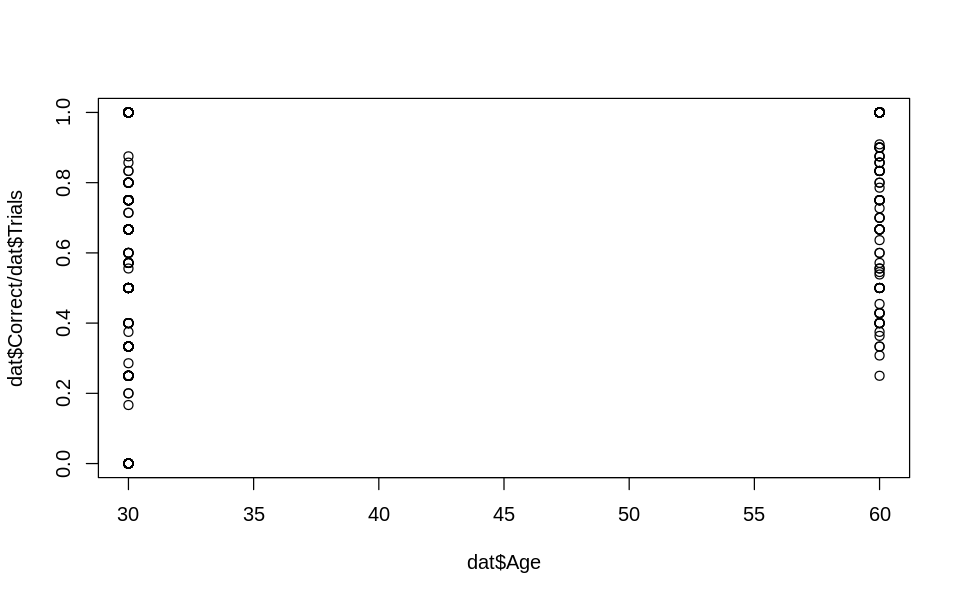

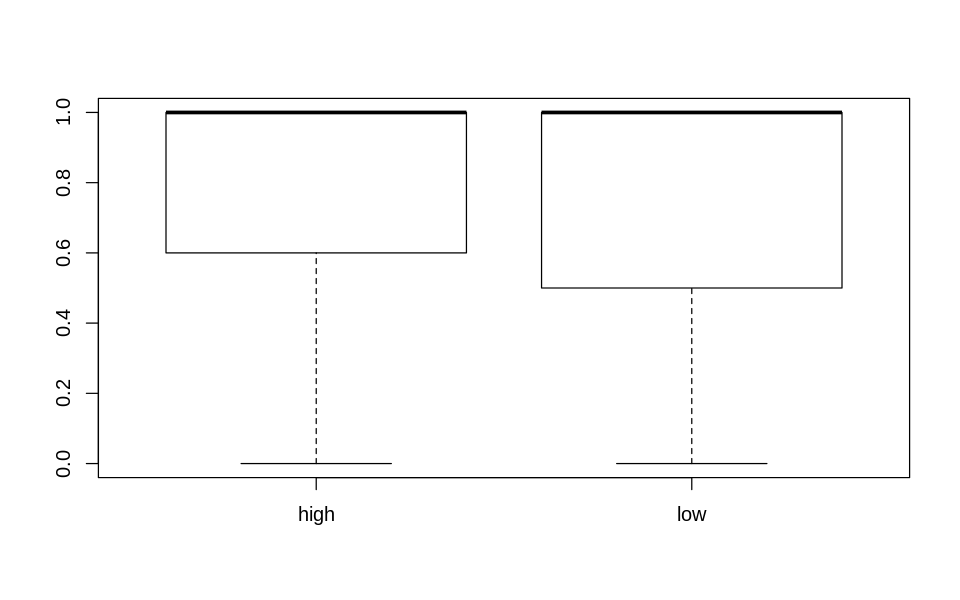

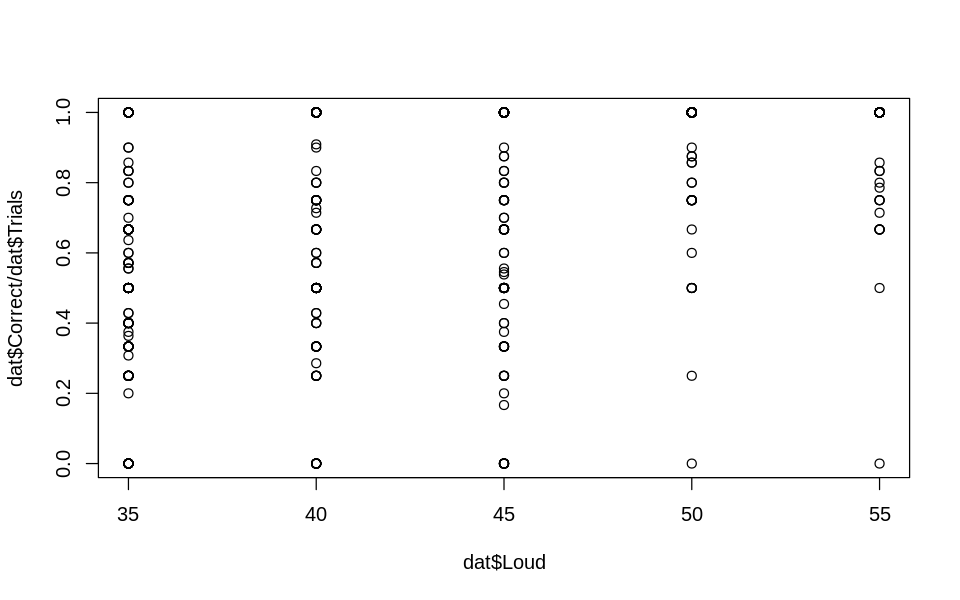

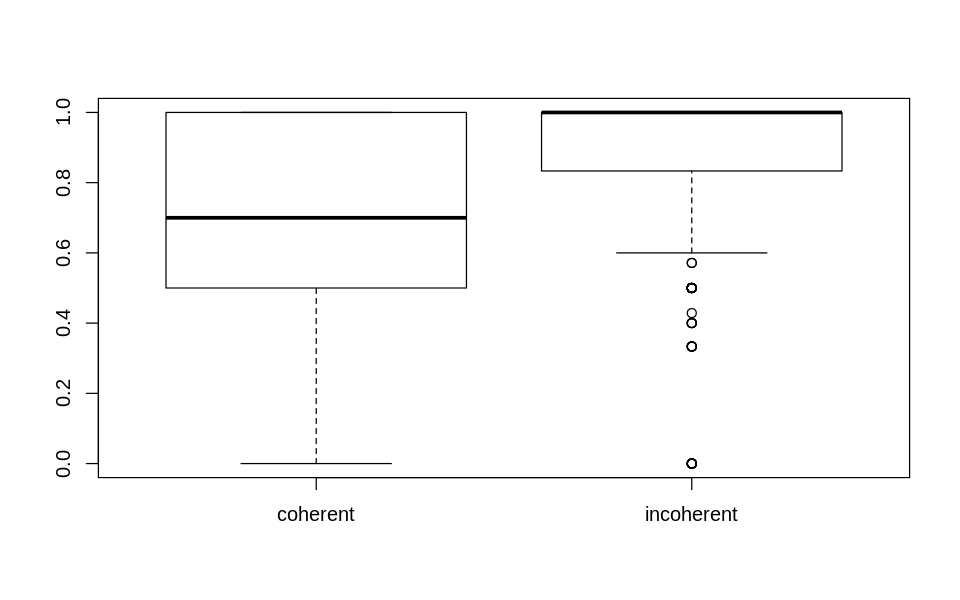

In [64]:
plot(dat$Age, dat$Correct / dat$Trials )
plot(dat$OME, dat$Correct / dat$Trials )
plot(dat$Loud, dat$Correct / dat$Trials )
plot(dat$Noise, dat$Correct / dat$Trials )

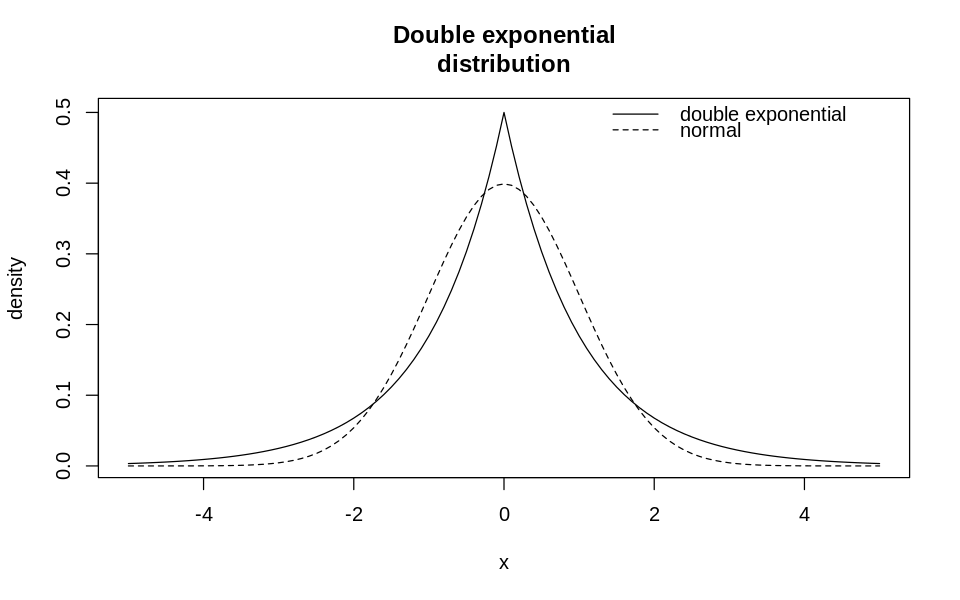

In [69]:
ddexp = function(x, mu, tau) {
  0.5*tau*exp(-tau*abs(x-mu)) 
}
curve(ddexp(x, mu=0.0, tau=1.0), from=-5.0, to=5.0, ylab="density", main="Double exponential\ndistribution") # double exponential distribution
curve(dnorm(x, mean=0.0, sd=1.0), from=-5.0, to=5.0, lty=2, add=TRUE) # normal distribution
legend("topright", legend=c("double exponential", "normal"), lty=c(1,2), bty="n")

In [104]:
mod_glm = glm(Correct/Trials ~ Age + OME + Loud + Noise, data=dat, weights=Trials, family="binomial")
summary(mod_glm)


Call:
glm(formula = Correct/Trials ~ Age + OME + Loud + Noise, family = "binomial", 
    data = dat, weights = Trials)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.8354  -0.3389   0.4296   0.8501   2.3694  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -7.294441   0.434928 -16.772  < 2e-16 ***
Age              0.018896   0.003767   5.016 5.28e-07 ***
OMElow          -0.237150   0.123257  -1.924   0.0544 .  
Loud             0.171682   0.008880  19.333  < 2e-16 ***
Noiseincoherent  1.576304   0.115236  13.679  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1431.12  on 711  degrees of freedom
Residual deviance:  732.38  on 707  degrees of freedom
AIC: 1262.6

Number of Fisher Scoring iterations: 5


In [66]:
coefficients(mod_glm)

(Intercept)             Age          OMElow            Loud Noiseincoherent 
     -7.2944412       0.0188960      -0.2371501       0.1716817       1.5763042

In [67]:
anova(mod_glm)

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,711,1431.1223
Age,1,25.444662,710,1405.6777
OME,1,3.922723,709,1401.7549
Loud,1,454.072629,708,947.6823
Noise,1,215.300753,707,732.3816


In [68]:
X = model.matrix(mod_glm)[,-1] # -1 removes the column of 1s for the intercept
head(X)

,Age,OMElow,Loud,Noiseincoherent
1,30,1,35,0
2,30,1,35,1
3,30,1,40,0
4,30,1,40,1
5,30,1,45,0
6,30,1,45,1


In [70]:
mod_string = " model {
for (i in 1:length(y)) {
    y[i] ~ dbin(phi[i], n[i])
    logit(phi[i]) = b0 + b[1]*Age[i] + b[2]*OMElow[i] + b[3]*Loud[i] + b[4]*Noiseincoherent[i]
    }
    
    b0 ~ dnorm(0.0, 1.0/5.0^2)
    for (j in 1:4) {
        b[j] ~ dnorm(0.0, 1.0/4.0^2)
    }    
} "
inits = function() {
    inits = list("b" = rnorm(4, 0, 16))
}
data_jags = as.list(as.data.frame(X))
data_jags$y = dat$Correct # this will not work if there are missing values in dat (because they would be ignored by model.matrix). Always make sure that the data are accurately pre-processed for JAGS.
data_jags$n = dat$Trials
str(data_jags) # make sure that all variables have the same number of observations (712).
#jags_glm = jags_model_compile(mod_string, data_jags, burnout = 1e3)
jags_glm = jags.model(textConnection(mod_string), data = data_jags, n.chains = 3)
update(jags_glm, 1e3)
#plot(residuals(mod_glm, type="deviance"))
#plot(fitted(mod_glm), dat$Correct/dat$Trials)

List of 6
 $ Age            : num [1:712] 30 30 30 30 30 30 30 30 30 30 ...
 $ OMElow         : num [1:712] 1 1 1 1 1 1 1 1 1 1 ...
 $ Loud           : num [1:712] 35 35 40 40 45 45 50 50 55 55 ...
 $ Noiseincoherent: num [1:712] 0 1 0 1 0 1 0 1 0 1 ...
 $ y              : int [1:712] 1 4 0 1 2 2 3 4 3 2 ...
 $ n              : int [1:712] 4 5 3 1 4 2 3 4 3 2 ...
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 712
   Unobserved stochastic nodes: 5
   Total graph size: 4392

Initializing model



In [71]:
jags_glm_sim = jags_model_sample(mod_ = jags_glm,  var_names_ = c("b0", "b"), n_iter_ = 5e3)

In [72]:
jags_glm_diag = jags_model_diag(samples_ = jags_glm_sim$samples)

In [76]:
head(jags_glm_sim$samples_cmb[,1:4])

Markov Chain Monte Carlo (MCMC) output:
Start = 1 
End = 7 
Thinning interval = 1 
           b[1]        b[2]      b[3]     b[4]
[1,] 0.02350183 -0.31729278 0.1637229 1.580701
[2,] 0.02412226 -0.28129322 0.1645960 1.640131
[3,] 0.02540589 -0.20238046 0.1655935 1.630167
[4,] 0.02421150 -0.11012497 0.1661624 1.750928
[5,] 0.02319187 -0.13516962 0.1668321 1.795056
[6,] 0.02343401 -0.08343549 0.1653025 1.515562
[7,] 0.02590408 -0.06069349 0.1653189 1.530846

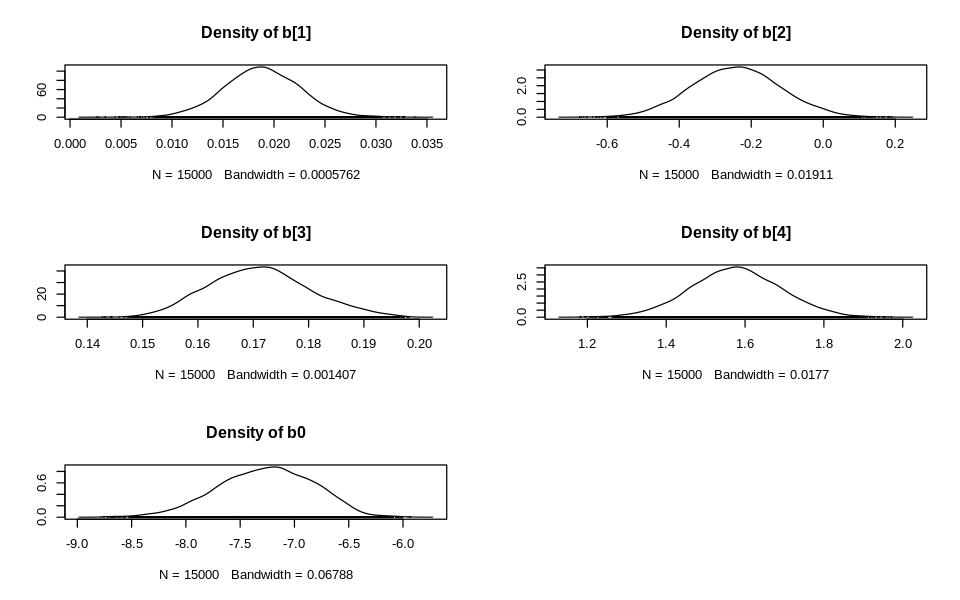

In [79]:
par(mfrow=c(3,2))
densplot(jags_glm_sim$samples_cmb[,1:5])

In [95]:
col_means = colMeans(jags_glm_sim$samples_cmb[,1:5])

In [116]:
col_means['b0']

b0 
-7.264204

In [110]:
y_est = c(60, 0, 50, 1, 1)

In [113]:
1/ ( 1 + exp( - t(col_means) %*% y_est))

0.9820372


In [121]:
cbind(head(X), "const" = 1)

,Age,OMElow,Loud,Noiseincoherent,const
1,30,1,35,0,1
2,30,1,35,1,1
3,30,1,40,0,1
4,30,1,40,1,1
5,30,1,45,0,1
6,30,1,45,1,1


In [130]:
install.packages("gtools")
library("gtools")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [125]:
Z = cbind(X, "c" = 1)

In [131]:
?inv.logit

In [133]:
phat = inv.logit(Z%*%col_means)

In [137]:
head(phat)

1,0.2788735
2,0.6518278
3,0.4764627
4,0.8150133
5,0.6817051
6,0.9120365


In [138]:
(tab0.7 = table(phat > 0.7, (dat$Correct / dat$Trials) > 0.7))
sum(diag(tab0.7)) / sum(tab0.7)

       
        FALSE TRUE
  FALSE   182   48
  TRUE     63  419

[1] 0.8441011

In [ ]:
dist(phat)